In [ ]:
#!rm -r dataset_aumentado/ Castas-Dataset-V1/
!wget --output-document dataset.zip https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
!unzip -o -q dataset.zip
!pip install lime



--2021-06-28 13:05:01--  https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip [following]
--2021-06-28 13:05:01--  https://www.dropbox.com/s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc83c13d5d804a2b7b7c6b3bdefd.dl.dropboxusercontent.com/cd/0/inline/BRSinQwpPL3_UQZdGgt_DB-8iuN3f1BfIMSumz_8oP8EuaBSKnAmHoOQPKRP5NM0kNG-5PPo70TJJUUH4Zl6BmJprCh3X6dGMjBo4IfOZt0mECG-qQV7PRwCE0d3OIHbDshNsuEMdlVEt2QT849BqT-I/file# [following]
--2021-06-28 13:05:01--  https://uc83c13d5d804a2b7b7c6b3bdefd.dl.dropboxusercontent.com/cd/0/inline/BRSinQwpPL3_UQZdGgt_DB-8iuN3f1BfIMSumz_8

In [ ]:
classes={
    'Codega':'CD',
    'Malvasia Fina':'MF',
    'Malvasia Preta':'MP',
    'Malvasia Rei':'MR',
    'Moscatel Galego':'MG',
    'Moscatel':'MG',
    'Mourisco Tinto':'MT',
    'Rabigato':'RG',
    'Tinta Amarela':'TA',
    'Tinta Barroca':'TB',
    'Tinta Roriz':'TR',
    'Tinto Cao':'TC',
    'Touriga Nacional':'TN'
}

Imports:

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import backend as K
from sklearn import metrics
import itertools
print('Notebook run using keras:', keras.__version__)
import random

nclasses = 12


Notebook run using keras: 2.5.0


Define diretórios

Monta google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#diretorio = '/content/gdrive/MyDrive/Castas-Dataset-V2-simplificado'
diretorio = '/content/dataset_aumentado/'
train_directory = os.path.join(diretorio, 'train')
val_directory = os.path.join(diretorio, 'validation')
#test_directory = diretorio
test_directory=os.path.join(diretorio, 'test')

Define modelo:

In [ ]:
#definicao do modelo
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications.xception import preprocess_input
target_size_dimension = 300


img_size = (target_size_dimension, target_size_dimension)
diretorio_pesos = '/content/gdrive/MyDrive/ana/exp 3/'
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(target_size_dimension, target_size_dimension, 3)
)
#x = Dense(2048, activation='relu')(model.output)
#x = Dropout(0.25)(x)
x = Dense(40, activation='relu')(model.output)
x = Dropout(0.25)(x)
output = Dense(nclasses, activation='softmax')(x)

nmodel = tf.keras.models.Model(model.input, output)
latest = tf.train.latest_checkpoint(diretorio_pesos)

nmodel.load_weights(latest)

#nome da ultima camada convolucional
last_conv_layer_name = 'block14_sepconv2_act'

83689472/83683744 [==============================] - 0s 0us/step


Matriz de confusão:

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_matrix(test_data_generator, model):
  test_data_generator.reset()
  predictions = model.predict(test_data_generator, steps=test_set.samples)
  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  print(class_labels)
  class_labels = [classes[x] for x in class_labels]  

  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = metrics.confusion_matrix(true_classes, predicted_classes)
  print(report)
  plot_confusion_matrix(cm, class_labels)

Transforma lista de imagens de teste:

In [ ]:
import pandas as pd
import glob
#metodo que itera pelos arquivos do diretorio salvando a path da imagem e sua respectiva classe
def directory_from_df_with_class(df, directory):
  for r, d, f in os.walk(directory):
    for file in f:
      row = {}
      row['path'] = os.path.join(r, file)
      
      row['class'] = row['path'].split('/')[-2]
      #print(row['class'])
      df= df.append(row, ignore_index=True)
  return df

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(target_size_dimension, target_size_dimension))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

columns_df = ['path', 'class']
df = pd.DataFrame(columns=columns_df)

df = directory_from_df_with_class(df, test_directory)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)
test_set = test_datagen.flow_from_directory(test_directory, 
                                            target_size=(target_size_dimension, target_size_dimension),
                                            class_mode='categorical',
                                            batch_size=1,
                                            shuffle=False)

test_set.reset()
predictions = nmodel.predict(test_set, steps=test_set.samples)




Found 72 images belonging to 12 classes.


Plotagem da matriz:

['Codega', 'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Moscatel Galego', 'Mourisco Tinto', 'Rabigato', 'Tinta Amarela', 'Tinta Barroca', 'Tinta Roriz', 'Tinto Cao', 'Touriga Nacional']
              precision    recall  f1-score   support

          CD       1.00      0.67      0.80         6
          MF       1.00      0.83      0.91         6
          MP       1.00      0.83      0.91         6
          MR       0.60      1.00      0.75         6
          MG       1.00      1.00      1.00         6
          MT       1.00      0.83      0.91         6
          RG       1.00      1.00      1.00         6
          TA       1.00      1.00      1.00         6
          TB       0.86      1.00      0.92         6
          TR       1.00      1.00      1.00         6
          TC       0.86      1.00      0.92         6
          TN       1.00      0.83      0.91         6

    accuracy                           0.92        72
   macro avg       0.94      0.92      0.92      

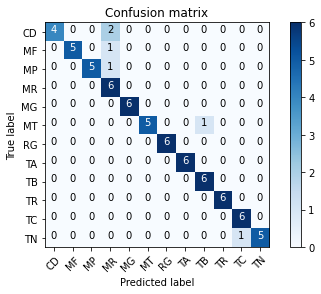

In [ ]:
confusion_matrix(test_set, nmodel)

Métodos utilizados para o grad-cam:

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
import tensorflow as tf
from PIL import Image

#define nome dos metodos que o keras usa para criar a visualização
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions


def get_img_array(img_path, size, expand=True):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    
    if expand:
      array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, grad_model, last_conv_layer_name, pred_index=None, tresh=0.1):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    #grad_model = tf.keras.models.Model(
        #[model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    #)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    tozero = heatmap < tresh
    heatmap[tozero] = 0.0
    return heatmap

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    im = Image.fromarray(heatmap)
    im = im.resize((img.shape[1], img.shape[0]))
    
    im = np.asarray(im)
    im = np.where(im > 0, 1, im)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

 

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img, im
 


gradcam++, adaptado de: https://github.com/samson6460/tf_keras_gradcamplusplus

In [ ]:
def grad_cam_plus(model, img,
                  layer_name="block5_conv3",
                  category_id=None, tresh=0.1):
    """Get a heatmap by Grad-CAM.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = tf.maximum(grad_CAM_map, 0) / tf.math.reduce_max(grad_CAM_map)
    #heatmap = np.maximum(grad_CAM_map, 0)
    #max_heat = np.max(heatmap)
    #if max_heat == 0:
        #max_heat = 1e-10
    #heatmap /= max_heat
    heatmap = heatmap.numpy()
    tozero = heatmap < tresh
    heatmap[tozero] = 0.0
    return heatmap

Verifica imagens que foram previstas errôneamente:

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes
largura = nclasses*2.5
erros = np.where(predicted_classes != true_classes)[0]
gradcam_statistics = []
paths=[]
#para executar nos erros
#for i in erros:
  #paths.append(test_set.filepaths[i])

#paths.append('/content/dataset_aumentado/test/Malvasia Fina/IMG_9858.JPG')
#para executar em todos
paths = test_set.filepaths

#importa lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

#nome do ultimo bloco convolucional da xception
last_conv_layer_name = "block14_sepconv2_act"

grad_model = tf.keras.models.Model([nmodel.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
np.random.seed(16)
explainer = lime_image.LimeImageExplainer()

def aply_mask2d_in_array(img, mask):
  copy_img = img.copy()

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if mask[i, j] == 0:
          for k in range(3):
            copy_img[i, j, k] = 0
  
  return copy_img


def decode_preds(preds, top=5):
  labels=(test_set.class_indices)
  labels2=dict((v,k) for k,v in labels.items())

  preds_return = []
  for pred in preds:
    sorted = -np.sort(-pred)[:top]
    pred = pred.tolist()
    greaters = [pred.index(x) for x in sorted]
    list2 = []
    for g in greaters:
      list2.append((labels2[g], pred[g]))
    
    preds_return.append(list2)
  
  return preds_return 

path_salvar = 'saida_lime'

if not os.path.exists(path_salvar):
  os.mkdir(path_salvar)
for i, img_path in enumerate(paths):
  print(img_path, ':')
  img = transform_img_fn([img_path])
  fig, ax = plt.subplots(1, nclasses+1, figsize=(largura,1.75))
  #plt.show()
  preds = nmodel.predict(img)
  #print(preds)
  
  class_img = img_path.split(os.path.sep)[-2]
  path_class = os.path.join(path_salvar, class_img)
  if not os.path.exists(path_class):
    os.mkdir(path_class)
  index = 0

  pr = decode_preds(preds, nclasses)[0]
  for i, x in enumerate(pr):
    print(x)
    if x[0] == class_img:
      index = i
  print('indice uitlizado pelo explicador: ', index)
  #plt.figure()
  %%time
  # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
  
  explanation = explainer.explain_instance(img[0].astype('double'), nmodel.predict, top_labels=12, hide_color=0, num_samples=1000)
  ax[0].imshow(Image.open(img_path))
  ax[0].set_title('Original')
  ax[0].axis('off')
  for m in range(nclasses):
    #colocando o positive only para melhorar a visualizacao
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[m], positive_only=True, num_features=15, hide_rest=True)
    
    ax[m+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax[m+1].set_title(pr[m][0])
    if m == index:
      ax[m+1].tick_params(color='green', labelcolor='green')
      for spine in ax[m+1].spines.values():
          spine.set_edgecolor('green')
    else:
      ax[m+1].axis('off')
  fig.savefig(os.path.join(path_class,img_path.split(os.path.sep)[-1].lower().split('.')[-2]+'.png'), dpi=300)
  plt.show()
  
  

  '''
          grad cam
  '''


  # Prepare image
  fig, ax = plt.subplots(1, nclasses+1, figsize=(largura,1.75))
  img_orginal_array = get_img_array(img_path, size=(target_size_dimension, target_size_dimension))
  img_array = preprocess_input(img_orginal_array.copy())

  ax[0].imshow(Image.open(img_path))
  ax[0].set_title('Original')
  ax[0].axis('off')

  for m in range(nclasses):
    heatmap = make_gradcam_heatmap(img_array, grad_model, last_conv_layer_name, pred_index=m)
    heat, mask = save_and_display_gradcam(img_path, heatmap)
    
    img = img_orginal_array[0,:,:,:]
    masked_image = aply_mask2d_in_array(np.array(heat),mask)
    masked_image = tf.keras.preprocessing.image.array_to_img(masked_image)
    #print(np.amax(masked_image), ' ', np.amin(masked_image))
    ax[m+1].imshow(masked_image) 
    ax[m+1].set_title(pr[m][0])
    if m == index:
      ax[m+1].tick_params(color='green', labelcolor='green')
      for spine in ax[m+1].spines.values():
          spine.set_edgecolor('green')
    else:
      ax[m+1].axis('off')
  
  fig.savefig(os.path.join(path_class,img_path.split(os.path.sep)[-1].lower().split('.')[-2]+'-gradcam.png'), dpi=300)
  plt.show()

  '''
          grad cam++
  '''


  # Prepare image
  fig, ax = plt.subplots(1, nclasses+1, figsize=(largura,1.75))
  img_orginal_array = get_img_array(img_path, size=(target_size_dimension, target_size_dimension), expand=False)
  img_array = preprocess_input(img_orginal_array.copy())

  ax[0].imshow(Image.open(img_path))
  ax[0].set_title('Original')
  ax[0].axis('off')


  for m in range(nclasses):
    heatmap = grad_cam_plus(nmodel, img_array, last_conv_layer_name, m)
    heat, mask = save_and_display_gradcam(img_path, heatmap)
    
    img = img_orginal_array
    masked_image = aply_mask2d_in_array(np.array(heat), mask)
    masked_image = tf.keras.preprocessing.image.array_to_img(masked_image)
    #print(np.amax(masked_image), ' ', np.amin(masked_image))
    ax[m+1].imshow(masked_image) 
    ax[m+1].set_title(pr[m][0])
    if m == index:
      ax[m+1].tick_params(color='green', labelcolor='green')
      for spine in ax[m+1].spines.values():
          spine.set_edgecolor('green')
    else:
      ax[m+1].axis('off')
  
  fig.savefig(os.path.join(path_class,img_path.split(os.path.sep)[-1].lower().split('.')[-2]+'-gradcampp.png'), dpi=300)
  plt.show()


  print('===============================')
  print('===============================')




  


In [ ]:
!rm saida_lime.zip
!zip -r -q saida_lime.zip saida_lime/*
!cp saida_lime.zip /content/gdrive/MyDrive 